In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
retail_df = pd.read_csv('retail_clean.csv', parse_dates=['InvoiceDate'])

In [3]:
max_date = retail_df['InvoiceDate'].max()

In [4]:
rf_df = retail_df.groupby('Customer ID').agg(recency = ('InvoiceDate', 'max'),
                                             frequency = ('Invoice', 'nunique'))

In [5]:
rf_df['recency'] = (max_date - rf_df['recency']).dt.days

In [6]:
m_df = retail_df.groupby(['Customer ID','Invoice']).agg({'Revenue':'sum'}).reset_index().groupby('Customer ID').agg(monetary = ('Revenue','median'))

In [7]:
rfm_df = pd.concat([rf_df,m_df],axis=1)

In [8]:
r_labels = range(3, 0, -1); fm_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
rfm_df['recency_cat'] = pd.qcut(rfm_df['recency'], q=3, labels=r_labels).astype(int)

# Assign these labels to three equal percentile groups 
rfm_df['frequency_cat'] = pd.qcut(rfm_df['frequency'], q=3, labels=fm_labels).astype(int)
rfm_df['monetary_cat'] = pd.qcut(rfm_df['monetary'], q=3, labels=fm_labels).astype(int)

In [9]:
rfm_df['RFM_score'] = rfm_df['recency_cat'] + rfm_df['frequency_cat'] + rfm_df['monetary_cat']

In [10]:
cltv = retail_df.groupby(['Customer ID']).agg({'Revenue':'sum'})

In [11]:
cltv_raw = cltv.copy()

In [12]:
# check for skewness and kurtosis, and perform log/cubic transformation if the data is skewed
for col in cltv:
    skew = cltv[col].skew()
    kurtosis = cltv[col].kurtosis()
    print(f'{col}:\nSkewness={skew}\nKurtosis={kurtosis}')
    if (skew < -1) or (skew > 1):
        transform = np.log(cltv[col])
        message = f'Log transformation on {col}'
        if transform.min() == float('-inf') or transform.max() == float('inf'): 
            transform = np.cbrt(cltv[col])
            message = f'Cubic transformation on {col}'
        cltv[col] = transform
        print(f'{message}\n')

Revenue:
Skewness=25.0760882762493
Kurtosis=830.5674608573285
Cubic transformation on Revenue



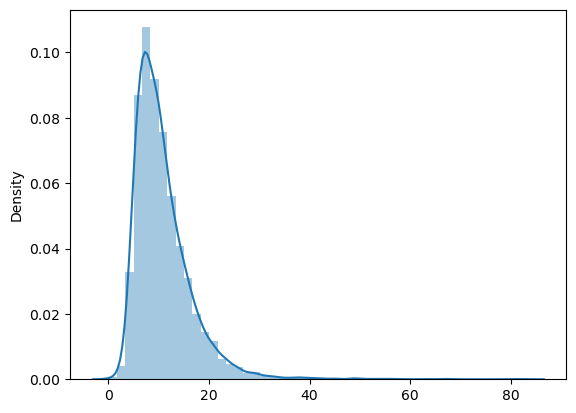

In [13]:
sns.distplot(cltv);

In [14]:
# create a function to standardize columns and plot residual errors for one cluster to ten clusters
def kmeans(X_features, min_range=1, max_range=11):
    scaler = StandardScaler()
    scaler.fit(X_features)
    X_norm = scaler.transform(X_features)
    X_norm = pd.DataFrame(X_norm, index=X_features.index, columns=X_features.columns)
    sse= []
    for k in range(min_range,max_range):
        kmeans= KMeans(n_clusters=k,n_init= 10,max_iter=300,tol=0.0001)
        a= kmeans.fit(X_norm)
        sse.append(a.inertia_)
    plt.plot(range(min_range,max_range),sse,'-');
    plt.plot(range(min_range,max_range),sse,'o');
    return X_norm

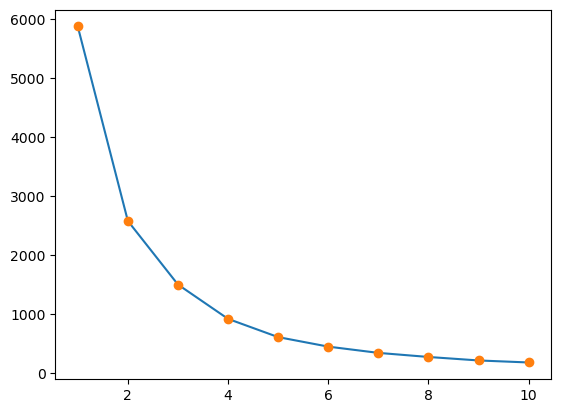

In [15]:
cltv_norm = kmeans(cltv)

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
kmeans.fit_predict(cltv)
cluster_labels = kmeans.labels_
cltv = cltv.assign(Cluster = cluster_labels)
df_melt = pd.melt(cltv, id_vars='Cluster', var_name='Attribute', value_name='Value')
pop_avg = cltv_raw.mean()
cltv_raw = cltv_raw.assign(Cluster = cluster_labels)
cluster_avg = cltv_raw.groupby('Cluster').mean()
relative_imp = cluster_avg/pop_avg - 1

<AxesSubplot: ylabel='Cluster'>

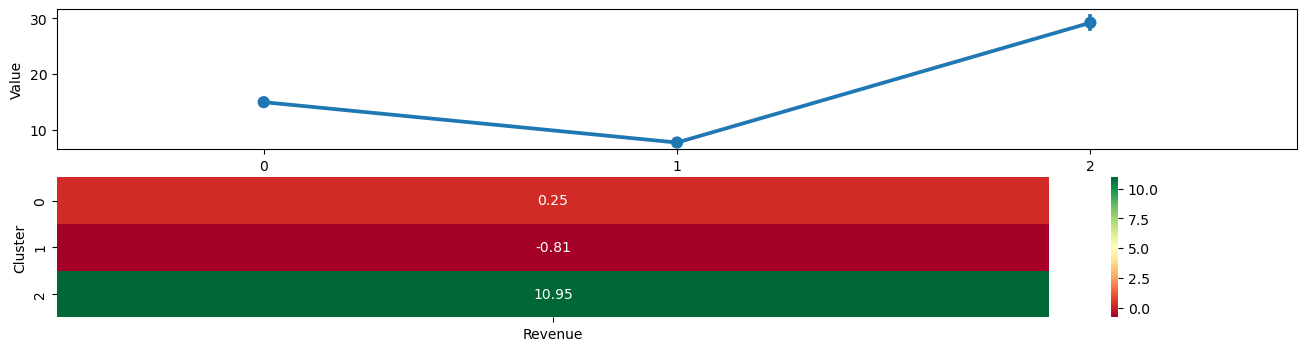

In [17]:
plt.figure(figsize=[16,4])
plt.subplot(2, 1, 1)
sns.pointplot(x='Cluster', y='Value', data=df_melt)
plt.subplot(2, 1, 2)
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')

In [18]:
cltv_raw.groupby('Cluster').mean()

,Revenue
Cluster,
0,3697.787551
1,550.861545
2,35307.346739


In [19]:
cltv_mapping = {0:'Mid CLTV', 1:'Low CLTV', 2:'High CLTV'}

In [20]:
cltv_raw['Cluster'] = cltv_raw['Cluster'].map(cltv_mapping)

In [21]:
cltv_cv = pd.concat([rfm_df, cltv_raw],axis=1)

In [22]:
cltv_cv = cltv_cv.drop('Cluster',axis=1)

In [24]:
model_tree = DecisionTreeClassifier()

In [25]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

In [26]:
scores = cross_val_score(model_tree, X=cltv_cv.values, y=cltv_raw['Cluster'].values,
                         scoring='accuracy', cv=cv)

In [27]:
scores

array([1.        , 0.9994898 , 1.        , 0.99949006, 1.        ,
       1.        , 1.        , 0.9994898 , 1.        ])

In [28]:
scores.mean()

0.9998299608811738

In [29]:
model_tree.fit(cltv_cv, cltv_raw['Cluster'])
prediction = model_tree.predict(cltv_cv)

In [30]:
comparison = pd.DataFrame({'Actual':cltv_raw['Cluster'],
                           'Predicted': prediction})

In [31]:
comparison.groupby(['Actual','Predicted']).size()

Actual     Predicted
High CLTV  High CLTV     241
Low CLTV   Low CLTV     3810
Mid CLTV   Mid CLTV     1830
dtype: int64